In [1]:
import pandas as pd
import numpy as np

import os
from zipfile import ZipFile

import requests
import json

import matplotlib.pyplot as plt
%matplotlib inline

## Step 0: 

This analysis research question will require several different datasets: 

1. The `RAW_us_confirmed_cases.csv` file from the [Kaggle repository](https://www.kaggle.com/antgoldbloom/covid19-data-from-john-hopkins-university?select=RAW_us_confirmed_cases.csv) of John Hopkins University COVID-19 data.
2. The [CDC dataset](https://data.cdc.gov/Policy-Surveillance/U-S-State-and-Territorial-Public-Mask-Mandates-Fro/62d6-pm5i) of masking mandates by county.
3. The New York Times [mask compliance survey data](https://github.com/nytimes/covid-19-data/tree/master/mask-use).  

The majority of this data is by US County by Day. The mask compliance is a single shot estimator that gives you a compliance estimate for every County in the US. You should carefully review the data descriptions that accompany these datasets. They each have some interesting caveats. As well, some of them are explicit with regard to the way you should interpret missing data.  

Lastly, you have been assigned a specific US County for analysis. You are NOT analyzing the entire dataset. You have been assigned one US County that forms the basis for your individual analysis. You can find your individual US County assignment from this Google spreadsheet.

###### Setup- specify county of interest
Assigned Montgomery County in Maryland

In [2]:
# setup- county of interest
# Montgomery, MD


state = 'Maryland'
st = 'MD'
county = 'Montgomery'

###### Get Cases data

In [3]:
# Unzip cases file

os.chdir('data_raw')

with ZipFile('RAW_us_confirmed_cases.csv.zip') as zipfiles:
    zipfiles.extractall()
    
os.chdir('..')

os.getcwd()

'C:\\Users\\admin\\Documents\\UW\\DATA512\\Assignments\\A4'

In [4]:
# load cases data

raw = pd.read_csv('data_raw/RAW_us_confirmed_cases.csv')

raw.columns

Index(['Province_State', 'Admin2', 'UID', 'iso2', 'iso3', 'code3', 'FIPS',
       'Country_Region', 'Lat', 'Long_',
       ...
       '10/23/21', '10/24/21', '10/25/21', '10/26/21', '10/27/21', '10/28/21',
       '10/29/21', '10/30/21', '10/31/21', '11/1/21'],
      dtype='object', length=661)

###### Get Mask policy data

In [5]:
# get mask policy data

'https://data.cdc.gov/resource/62d6-pm5i.json?state_tribe_territory=TX&county'

base_url = 'https://data.cdc.gov/resource/62d6-pm5i.json?state_tribe_territory={st}&county_name={county}'

params = {
    'st' : st,
    'county' : county + ' County'
}
mask_url = base_url.format(**params)
masks_json = requests.get(mask_url).json()

masks_df = pd.DataFrame.from_dict(masks_json)
masks_df.shape

(493, 10)

###### Get mask compliance data

In [6]:
# get mask compliance data

compliance_url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/mask-use/mask-use-by-county.csv'
compliance_df = pd.read_csv(compliance_url)

compliance_df.head()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459


##### Filter based on given county

In [7]:
# filter

cases_filter = raw.loc[(raw.Province_State==state) & (raw.Admin2==county)].copy().reset_index(drop=True)

fips_county = int('10' + masks_df.fips_county[0])

compliance_filter = compliance_df.loc[compliance_df.COUNTYFP==fips_county].copy().reset_index(drop=True)

## Step 1: Analyze

The common question that you are to answer is:

- How did masking policies change the progression of confirmed COVID-19 cases from February 1, 2020 through October 15, 2021?  

Answering this question can be a little tricky - and it will be useful for you all (whole class) to discuss this on Slack. We will also spend some time in class on this discussion. Some of the issues that you probably should consider when conducting your analysis include:
1. What needs to be cleaned and standardized over the three datasets?
2. There is a delay between the time of infection and the time a case is confirmed. Many factors may contribute to such delay. People may not show symptoms right away after infection. It may take a few days for the testing results to become available especially during the early period of the pandemic. Should we model the delay?
3. Masking may simply make it longer to get infected or it may prevent some percentage of infection. How should we consider the effect of a mask?
4. The research question is about how a time series changes. The infection time series is a set of slopes. Therefore the question is about a derivative function. That is, you want to answer a question about the change in slope over time. How can we test the difference in the derivative function?
5. Masking survey data shows probability of compliance in several categories. How can we model different proportions for population compliance?
6. Masking policies varied in their implementation (e.g., size of “crowd” required, different situations, restaurants, bars, clubs ...). How should I handle things when my County implemented two different policies at different times?
7. The County I was assigned did not implement a masking policy! What is a reasonable way to answer this question? That is, how might I model “voluntary” masking?
8. Vaccinations probably impacted the apparent effectiveness of masks. How should we account for different vaccination rates in different populations within the same County?  

We note that we did not enumerate all potential issues that you may want to discuss. Further, there are some better and worse ways to handle these questions. We are not looking for the one right answer. We are looking for reasonable solutions. There are aspects of this problem that are very hard to model - and so you will probably want to make simplifying assumptions. For example, you might decide to ignore the impacts of vaccinations or consider pre-vaccine availability as one time series and post-vaccine availability as a totally different time series. 

###### Define additional datapoints that are initially given

In [8]:
# additional data

pop = 1062061 # given
sq_mi = 491.25 # given
sq_km = 1272.34 # given

##### Cases dataset

In [9]:
# cases have dates in columns- transpose to have each entry as rows
# also convert dates to datetime

cases = cases_filter[cases_filter.columns[11:]].T.reset_index().rename(columns={'index':'date', 0:'cases'})

cases.date = pd.to_datetime(cases.date)

<AxesSubplot:xlabel='date'>

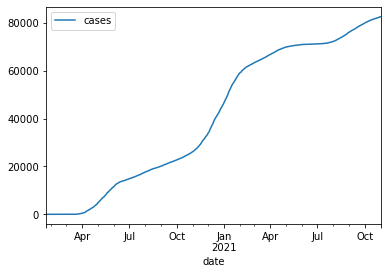

In [10]:
#quick visualization

cases.plot(x='date', y='cases')

<AxesSubplot:xlabel='date'>

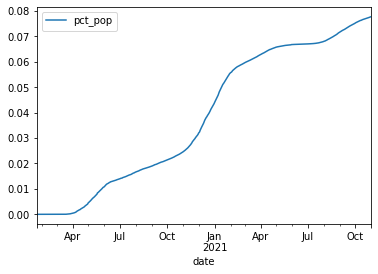

In [11]:
# cases per population

cases['pct_pop'] = cases.cases/pop

# same, just different units 
cases.plot(x='date', y='pct_pop')

###### Masks dataset

In [12]:
# look at data types

for col in mask_df.columns:
    print('Data type for column {} is {}'.format(col, type(mask_df[col][0])))

NameError: name 'mask_df' is not defined

In [ ]:
# convert data types
# dates to datetime
# order_code to int

masks_df.date = pd.to_datetime(masks_df.date)
masks_df.order_code = masks_df.order_code.astype(int)

In [ ]:
# quick visualization

masks_df.plot(x='date', y='order_code')

##### Mask compliance dataset

In [ ]:
# also setup as columns --> transpose to show each entry as rows
# also show as magnitude 

mask_comp = compliance_filter.drop(columns=['COUNTYFP']).T.reset_index().rename(columns={'index':'response',0:'pct_pop'})
mask_comp['pop'] = mask_comp.pct_pop * pop

mask_comp

###### Merging datasets

In [ ]:
# helper function

def case_per_pop(df, subset):
    """
    Helper function to join mask compliance population % with cases dataset
    df: pd.DataFrame
        Cases dataframe
    subset: str
        String of mask compliance category
    Returns: new pd.DataFrame with columns added for population given mask compliance response
    """
    
    subset_pop = mask_comp.loc[mask_comp.response==subset]['pop'].values[0]
    df[subset.lower()] = subset_pop
    
    return df

In [ ]:
# apply helper function- populate columns with mask compliance population

cases_mask = cases.copy()

for resp in mask_comp.response:
    cases_mask = case_per_pop(cases_mask, resp)

In [ ]:
# additional merge- merge case + compliance with mask order code

cases_merge = cases_mask.merge(masks_df[['order_code', 'date']], on='date')

##### Getting daily cases

In [ ]:
# get daily cases- daily difference between total cases

cases_merge['daily_cases'] = cases_merge.cases - cases_merge.cases.shift(1)

In [ ]:
# quick visualization

cases_merge.plot(x='date', y='daily_cases')

###### Get rolling average

In [ ]:
# Helper function

def get_rolling_avg(df, days):
    
    col_name = 'rolling_avg_' + str(days)
    df[col_name] = df.daily_cases.rolling(days).mean()
    
    return df

In [ ]:
# get rolling average- 7 day

cases_merge = get_rolling_avg(cases_merge, 7)

# get rolling average- 14 day

cases_merge = get_rolling_avg(cases_merge, 14)

In [ ]:
# quick visualization - 7 day

cases_merge.plot(x='date', y='rolling_avg_7')

In [ ]:
# quick visualization - 14 day

cases_merge.plot(x='date', y='rolling_avg_14')

##### Getting change in daily cases

In [ ]:
# helper function

def get_pct_chg(df, days):
    
    col_name = 'pct_chg_' + str(days) + 'D_avg'
    pct_col = 'rolling_avg_' + str(days)
    df[col_name] = df[pct_col].pct_change(1)
    
    return df

In [ ]:
# get pct change- 7 days RA

cases_merge = get_pct_chg(cases_merge, 7)

# get pct change- 14 days RA

cases_merge = get_pct_chg(cases_merge, 14)

# get pct change- daily 

cases_merge['pct_chg_daily'] = cases_merge.daily_cases.pct_change(1)

In [ ]:
# quick visualization 7D pct chg

cases_merge.plot(x='date', y='pct_chg_7D_avg')

In [ ]:
# quick visualization 14D pct chg

cases_merge.plot(x='date', y='pct_chg_14D_avg')

In [ ]:
# quick visualization daily pct chg

cases_merge.plot(x='date', y='pct_chg_daily')

In [ ]:
# recap- what do we have so far

cases_merge.head()

## Step 2: Visualize

In this step we want you to create a graph that visualizes how the course of the disease was changed by masking policies. For your county, you should create a time series showing the changes in the derivative function of the rate of infection. Your graph should indicate days where masking policies were in effect (or not) and whether the difference in the derivative function was significant. Optionally, you can add a second time series that shows the actual rate of infection.  

In [ ]:
# helper function- get masked array

def get_ma(var, order):
    return np.ma.masked_where(cases_merge.order_code==order, cases_merge[var])

In [ ]:
# get masked arrays (for different masking orders)

daily_mask = get_ma('daily_cases', 2)
daily_no_mask = get_ma('daily_cases', 1)
total_mask = get_ma('cases', 2)
total_no_mask = get_ma('cases', 1)
roll7_avg_mask = get_ma('rolling_avg_7', 2)
roll7_avg_no_mask = get_ma('rolling_avg_7', 1)
roll14_avg_mask = get_ma('rolling_avg_14', 2)
roll14_avg_no_mask = get_ma('rolling_avg_14', 1)

In [ ]:
fig = plt.figure(figsize=(20, 10), facecolor='white')
ax = fig.add_subplot()

ax.set_title('Daily COVID19 Cases in Montegomery County, MD \nFeb 1 2020 - Oct 15 2021')


# plot daily cases
ax.bar(cases_merge.date, daily_mask, alpha=0.8, linewidth=2, color='grey',
        label='Daily Cases-Mask Mandate (LHS)')
ax.bar(cases_merge.date, daily_no_mask, alpha=0.5, color='grey', label='Daily Cases-No Mask Mandate (LHS)')

# plot rolling avg 7D
ax.plot(cases_merge.date, roll7_avg_mask, alpha=0.8, linewidth=2, color='crimson', 
        label='7D Rolling Avg of Cases-Mask Mandate (LHS)')
ax.plot(cases_merge.date, roll7_avg_no_mask, alpha=0.5, color='crimson', linestyle='dashed',
        label='7D Rolling Avg of Cases-No Mask Mandate (LHS)')

# plot rolling avg 14D
ax.plot(cases_merge.date, roll14_avg_mask, alpha=0.8, linewidth=2, color='darkblue', 
        label='14D Rolling Avg of Cases-Mask Mandate (LHS)')
ax.plot(cases_merge.date, roll14_avg_no_mask, alpha=0.5, color='darkblue', linestyle='dashed',
        label='14D Rolling Avg of Cases-No Mask Mandate (LHS)')

# set labels
ax.set_xlabel('Date')
ax.set_ylabel('Number of Positive Cases')
plt.legend(loc='upper left')

ax2 = ax.twinx()
ax2.plot(cases_merge.date, total_mask, c='darkgreen', alpha=0.6, linewidth=5, label='Total Cases-Mask Mandate (RHS)')
ax2.plot(cases_merge.date, total_no_mask, c='darkgreen', alpha=0.3, linewidth=3, 
         linestyle='dashed', label='Total Cases-No Mask Mandate (RHS)')
ax2.set_ylabel('Number of Positive Cases')

#ax.fill_between(cases_merge.date, np.nanmin(cases_merge.daily_cases), np.nanmax(cases_merge.daily_cases), 
#               where=cases_merge.order_code==1, color='blue', alpha=0.3)

plt.legend(loc='upper right')

plt.savefig('visualization/plot.png', facecolor=fig.get_facecolor(), bbox_inches='tight')